In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
import re
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import mannwhitneyu
from scipy import stats
import matplotlib.ticker as ticker
import os
from reload_recursive import reload_recursive
import patsy
from pyprocessmacro import Process
from statsmodels.stats.mediation import Mediation
from statsmodels.miscmodels.ordinal_model import OrderedModel
from pingouin import mediation_analysis

from mri_data import file_manager as fm
import helpers

In [3]:
reload_recursive(helpers)

## Setup

In [4]:
drive_root = fm.get_drive_root()
msmri_home = Path("/home/srs-9/Projects/ms_mri")
msmri_datadir = msmri_home / "data"
curr_dir = Path(os.getcwd())
data_dir = curr_dir / "data0"
showfigs = False

In [5]:
df = pd.read_csv(data_dir / "t1_data_full.csv")
df = df.set_index("subid")

df = helpers.set_dz_type5(df)
df = helpers.set_dz_type3(df)
df = helpers.set_dz_type2(df)
df = helpers.fix_edss(df)
df = helpers.clean_df(df)

keep_cols = [
    "subject",
    "age",
    "sex",
    "ms_type",
    "dz_type2",
    "dz_type3",
    "dz_type5",
    "dzdur",
    "EDSS",
    "MSSS",
    "gMSSS",
    "ARMSS",
    "DMT_score",
    "DMT_hx_all",
    "flair_contrast",
    "lesion_count",
    "lesion_vol_cubic",
    "PRL",
    "tiv",
    "choroid_volume",
    "pineal_volume", 
    "pituitary_volume"
]

df = df.loc[:, keep_cols]
df = pd.concat((df, pd.get_dummies(df["sex"], dtype="int")), axis=1)
df["Intercept"] = 1

In [6]:
df.loc[:, "lesion_vol_logtrans"] = np.log(df["lesion_vol_cubic"])
df.loc[:, "edss_sqrt"] = np.sqrt(df["EDSS"].astype("float"))
df.loc[:, "msss_sqrt"] = np.sqrt(df["MSSS"])
df.loc[:, "armss_sqrt"] = np.sqrt(df["ARMSS"])
df.loc[:, "gmsss_sqrt"] = np.sqrt(df["gMSSS"])

In [7]:
vars = [
    "age",
    "Female",
    "dzdur",
    "EDSS",
    "MSSS",
    "gMSSS",
    "ARMSS",
    "edss_sqrt",
    "msss_sqrt",
    "armss_sqrt",
    "gmsss_sqrt",
    "DMT_score",
    "DMT_hx_all",
    "lesion_count",
    "lesion_vol_cubic",
    "lesion_vol_logtrans",
    "PRL",
    "tiv",
    "choroid_volume",
]

for var in vars:
    df[var] = pd.to_numeric(df[var])

In [8]:
vars_to_center = ["edss_sqrt", "lesion_vol_logtrans", "lesion_vol_cubic", "dzdur", "choroid_volume"]

for var in vars_to_center:
    df[f"{var}_cent"] = df[var] - df[var].mean()

centered_vars = [f"{var}_cent" for var in vars_to_center]
vars.extend(centered_vars)

In [9]:
vars_to_scale = [
    "age",
    "dzdur",
    "lesion_count",
    "lesion_vol_cubic",
    "lesion_vol_logtrans",
    "PRL",
    "tiv",
    "choroid_volume",
]

df_scale = df.copy()
df_scale[vars_to_scale] = df_scale[vars_to_scale] / df_scale[vars_to_scale].mean()

In [12]:
df_ms = df.loc[df['dz_type2'] == "MS"]
df_scale_ms = df_scale.loc[df['dz_type2'] == "MS"]

df_z = df[vars].astype("float")
df_z[df.columns[~df.columns.isin(vars)]] = df[df.columns[~df.columns.isin(vars)]]
df_z = df_z[df.columns]
df_z[vars] = df_z[vars].apply(stats.zscore, nan_policy="omit")

data = df[vars].astype("float")
data_z = data[vars].apply(stats.zscore, nan_policy="omit")

data_ms = df.loc[df["dz_type5"].isin(["RMS", "PMS"]), :]
data_ms = data_ms[vars].astype("float")
data_ms_z = data_ms[vars].apply(stats.zscore, nan_policy="omit")

In [13]:
r_data_dir = Path("/mnt/c/Users/srs-9/Dev/ms_mri/analysis/paper1/data")
df.dropna().to_csv(r_data_dir / "proc_data.csv")
df_ms.dropna().to_csv(r_data_dir / "proc_data_ms.csv")
df_scale.dropna().to_csv(r_data_dir / "proc_data_scale.csv")
df_scale_ms.dropna().to_csv(r_data_dir / "proc_data_scale_ms.csv")

## Analysis

### Choroid Volumes

CP volume increased with age (β=0.38, p<0.001), TIV (β=0.16, p=0.001), and was smaller in females (β=-0.15, p=0.002), but was not associated with the presence of MS (β=0.18, p=0.10)

In [11]:
model_data = df_z[df_z['dz_type2'].isin(["MS", "!MS"])]
res = sm.OLS.from_formula(
    "choroid_volume ~ dz_type2 + age + tiv + Female", data=model_data
).fit()

summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues})
print("R2:     {:0.3f}".format(res.rsquared))
print("R2_adj: {:0.3f}".format(res.rsquared_adj))
print(summary)

R2:     0.236
R2_adj: 0.230
                    coef             p
Intercept      -0.150227  1.433637e-01
dz_type2[T.MS]  0.182786  1.021872e-01
age             0.384761  1.688386e-19
tiv             0.160233  1.070275e-03
Female         -0.153129  1.849241e-03


Within the population of MS patients, those with PMS had greater CP volumes than those with RMS, after controlling for age, sex, and TIV (β=0.36, p=0.003). 

In [12]:
model_data = df_z[df_z['dz_type5'].isin(["RMS", "PMS"])]
res = sm.OLS.from_formula("choroid_volume ~ dz_type5 + Female + age + tiv", data=model_data).fit()

summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues})
print("R2:     {:0.3f}".format(res.rsquared))
print("R2_adj: {:0.3f}".format(res.rsquared_adj))
print(summary)

R2:     0.254
R2_adj: 0.246
                     coef             p
Intercept        0.314614  3.053937e-03
dz_type5[T.RMS] -0.358740  3.328932e-03
Female          -0.162634  2.373544e-03
age              0.320690  8.375234e-11
tiv              0.134778  1.163134e-02


In a multivariable regression controlling for age, sex, and TIV, CP volume increased with WM lesion volume (β=0.21, p<0.001) and number of PRL lesions (β=0.16, p<0.001). There was still a significant positive association with PMS (β=0.27. p=0.019)

In [13]:
model_data = df_z[df_z['dz_type5'].isin(["RMS", "PMS"])]
res = sm.OLS.from_formula("choroid_volume ~ lesion_vol_cubic + PRL + dz_type5 + Female + age + tiv", data=model_data).fit()

summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues})
print("R2:     {:0.3f}".format(res.rsquared))
print("R2_adj: {:0.3f}".format(res.rsquared_adj))
print(summary)

R2:     0.334
R2_adj: 0.325
                      coef             p
Intercept         0.220771  3.096051e-02
dz_type5[T.RMS]  -0.274278  1.941262e-02
lesion_vol_cubic  0.212075  4.608245e-06
PRL               0.162715  7.904203e-05
Female           -0.165620  1.138366e-03
age               0.322206  1.198592e-10
tiv               0.109367  3.140712e-02


An ANCOVA was conducted to examine differences in CP volume amongst the RMS, PMS, OIND, and NIND groups, controlling for age, sex, and TIV. The analysis revealed a significant main effect for disease phenotype on CP volume (p < 0.001). Post hoc Tukey's HSD comparisons indicated that PMS had significantly larger CP than both NIND (p=0.043, d=0.51) and RMS (p=0.011, d=0.42). Additionally, sex (p<0.001), age (p<0.001), and TIV (p=0.006) were significant covariates. 

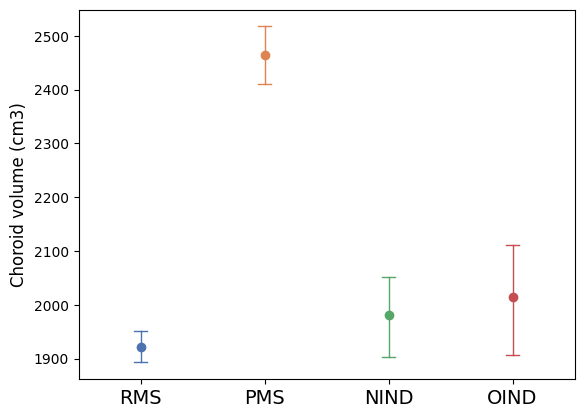

In [14]:
model_data = df[df['dz_type5'].isin(["RMS", "PMS", "NIND", "OIND"])]

res = sm.OLS.from_formula("choroid_volume ~ dz_type5 + Female + age + tiv", data=model_data).fit()
# Extract marginal means (using 'Group')
marginal_means = res.predict(model_data[['Female', 'age', 'tiv', 'dz_type5']].drop_duplicates())

f = plt.figure()
ax = sns.pointplot(x='dz_type5', y=marginal_means, data=model_data, 
              palette='deep', hue='dz_type5', legend=False, markers='o', linestyles='-', color='red', 
              capsize=0.1, markersize=5, markeredgewidth=2, linewidth=1)
ax.set_ylabel("Choroid volume (cm3)", fontsize=12)
ax.set_xlabel("")
ax.set_xticks(["RMS", "PMS", "NIND", "OIND"])
ax.set_xticklabels(["RMS", "PMS", "NIND", "OIND"], fontsize=14)
f.patch.set_alpha(0)

The best performing regression model for predicting CP volume in MS patients had an R² of 0.37 (adj R²=0.35).

In [15]:
model_data = df[df['dz_type5'].isin(["RMS", "PMS"])]

res = sm.OLS.from_formula("choroid_volume ~ MSSS + DMT_hx_all + dz_type5 + lesion_vol_cubic + lesion_count + PRL + Female + age + tiv", data=model_data).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         choroid_volume   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     23.84
Date:                Sat, 22 Feb 2025   Prob (F-statistic):           5.10e-32
Time:                        15:05:10   Log-Likelihood:                -2899.9
No. Observations:                 376   AIC:                             5820.
Df Residuals:                     366   BIC:                             5859.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          682.2914    473.217  

### Clinical Disability

In [ ]:
model_data = data.copy()
model_data = model_data.loc[df['dz_type5'].isin(["RMS", "PMS"]), :]
predictors = ["choroid_volume", "tiv", "age", "Female"]
outcome = ["EDSS"]
model_data[predictors] = model_data[predictors].apply(stats.zscore, nan_policy='omit')

model_data2 = data.copy()
model_data2['age'] = model_data2['choroid_volume'] - (model_data2['choroid_volume']).mean()

model = sm.OLS.from_formula("edss_sqrt ~ lesion_vol_cubic + choroid_volume + tiv + age + Female", data=model_data)
res = model.fit()
print(res.summary())
# print("p values:")
# print("Choroid volume: {:0.2}".format(res_prob.pvalues['choroid_volume']))
# print("Lesion volume:  {:0.2}".format(res_prob.pvalues['lesion_vol_cubic']))

                            OLS Regression Results                            
Dep. Variable:              edss_sqrt   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     25.09
Date:                Sat, 22 Feb 2025   Prob (F-statistic):           6.06e-22
Time:                        15:05:10   Log-Likelihood:                -290.19
No. Observations:                 397   AIC:                             592.4
Df Residuals:                     391   BIC:                             616.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.3810      0.060  

#### Original Data

In [372]:
predictors = ["lesion_vol_cubic", "choroid_volume", "tiv", "age", "Female"]
vars_to_center = ['choroid_volume', 'tiv', 'lesion_vol_cubic']
outcome = ["EDSS"]

model_data = data.copy()
model_data = model_data.loc[df['dz_type5'].isin(["RMS", "PMS"]), :].dropna()
mod_prob = OrderedModel.from_formula("EDSS ~ lesion_vol_cubic + choroid_volume + tiv + age + Female",
                                     data=model_data, distr='logit')
res_prob = mod_prob.fit(method='powell')
res_prob.summary()

Optimization terminated successfully.
         Current function value: 2.183780
         Iterations: 6
         Function evaluations: 1537


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                   EDSS   Log-Likelihood:                -821.10
Model:                   OrderedModel   AIC:                             1686.
Method:            Maximum Likelihood   BIC:                             1773.
Date:                Fri, 21 Feb 2025                                         
Time:                        22:14:27                                         
No. Observations:                 376                                         
Df Residuals:                     354                                         
Df Model:                           5                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
lesion_vol_cubic     0.4075      0.130      3.137      0.002       0.153       0.662
choroid_volume       0.0004      0.000      2.485      0.013    8.32e-05       0.001
tiv               -1.02e-06   1.67e-07     -6.113      0.000   -1.35e-06   -6.93e-07
age                  0.0499      0.008      5.901      0.000       0.033       0.066
Female              -0.1383      0.234     -0.590      0.555      -0.598       0.321
0.0/1.0             -2.0264      0.593     -3.416      0.001      -3.189      -0.864
1.0/1.5              0.8965      0.143      6.268      0.000       0.616       1.177
1.5/2.0              0.3915      0.092      4.265      0.000       0.212       0.571
2.0/2.5             -0.2715      0.123     -2.215      0.027      -0.512      -0.031
2.5/3.0             -1.2812      0.217     -5.906      0.000      -1.706      -0.856
3.0/3.5             -1.1412      0.206     -5.530      0.000      -1.546      -0.737
3.5/4.0             -1.2001      0.223     -5.387      0.000      -1.637      -0.763
4.0/4.5             -1.2660      0.244     -5.199      0.000      -1.743      -0.789
4.5/5.0             -2.5879      0.496     -5.218      0.000      -3.560      -1.616
5.0/5.5             -1.9828      0.373     -5.314      0.000      -2.714      -1.251
5.5/6.0             -2.2532      0.443     -5.087      0.000      -3.121      -1.385
6.0/6.5             -0.1825      0.176     -1.037      0.300      -0.528       0.162
6.5/7.0              0.0160      0.228      0.070      0.944      -0.430       0.462
7.0/7.5             -0.9331      0.497     -1.876      0.061      -1.908       0.042
7.5/8.0             -0.8473      0.576     -1.472      0.141      -1.975       0.281
8.0/8.5             -0.3293      0.583     -0.565      0.572      -1.471       0.813
8.5/9.0              0.1055      0.740      0.143      0.887      -1.344       1.555
====================================================================================
"""

#### Scaled

In [67]:
model_data_scale = data.copy()
model_data_scale = model_data_scale.loc[df['dz_type5'].isin(["RMS", "PMS"]), :].dropna()

model_data_scale[vars_to_center] = model_data_scale[vars_to_center] / model_data_scale[vars_to_center].mean()

mod_prob = OrderedModel.from_formula("EDSS ~ choroid_volume + tiv + age + Female + dzdur",
                                     data=model_data_scale, distr='logit')
res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 2.176648
         Iterations: 74
         Function evaluations: 150
         Gradient evaluations: 138


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                   EDSS   Log-Likelihood:                -818.42
Model:                   OrderedModel   AIC:                             1681.
Method:            Maximum Likelihood   BIC:                             1767.
Date:                Sat, 22 Feb 2025                                         
Time:                        15:27:38                                         
No. Observations:                 376                                         
Df Residuals:                     354                                         
Df Model:                           5                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
choroid_volume     0.5939      0.314      1.894      0.058      -0.021       1.208
tiv            -8.704e-07   1.67e-07     -5.209      0.000    -1.2e-06   -5.43e-07
age                0.0439      0.010      4.529      0.000       0.025       0.063
Female            -0.3019      0.238     -1.269      0.204      -0.768       0.164
dzdur              0.5091      0.149      3.410      0.001       0.216       0.802
0.0/1.0           -2.6649      0.627     -4.248      0.000      -3.894      -1.435
1.0/1.5            0.9169      0.149      6.148      0.000       0.625       1.209
1.5/2.0            0.3960      0.092      4.287      0.000       0.215       0.577
2.0/2.5           -0.2694      0.123     -2.192      0.028      -0.510      -0.029
2.5/3.0           -1.2653      0.218     -5.814      0.000      -1.692      -0.839
3.0/3.5           -1.1291      0.207     -5.454      0.000      -1.535      -0.723
3.5/4.0           -1.1906      0.223     -5.331      0.000      -1.628      -0.753
4.0/4.5           -1.2497      0.244     -5.123      0.000      -1.728      -0.772
4.5/5.0           -2.5731      0.497     -5.179      0.000      -3.547      -1.599
5.0/5.5           -1.9705      0.374     -5.274      0.000      -2.703      -1.238
5.5/6.0           -2.2471      0.443     -5.068      0.000      -3.116      -1.378
6.0/6.5           -0.1661      0.176     -0.944      0.345      -0.511       0.179
6.5/7.0            0.0313      0.227      0.138      0.890      -0.414       0.476
7.0/7.5           -0.9361      0.498     -1.881      0.060      -1.912       0.040
7.5/8.0           -0.8520      0.576     -1.479      0.139      -1.981       0.277
8.0/8.5           -0.3346      0.583     -0.574      0.566      -1.478       0.809
8.5/9.0            0.1042      0.740      0.141      0.888      -1.346       1.554
==================================================================================
"""

In [384]:
model_data_scale = data.copy()
model_data_scale = model_data_scale.loc[df['dz_type5'].isin(["RMS", "PMS"]), :].dropna()

model_data_scale[vars_to_center] = model_data_scale[vars_to_center] / model_data_scale[vars_to_center].mean()

mod_prob = OrderedModel.from_formula("EDSS ~ lesion_vol_cubic + choroid_volume + tiv + age + Female",
                                     data=model_data_scale, distr='logit')
res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

Optimization terminated successfully.
         Current function value: 2.181499
         Iterations: 92
         Function evaluations: 97
         Gradient evaluations: 97


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                   EDSS   Log-Likelihood:                -820.24
Model:                   OrderedModel   AIC:                             1684.
Method:            Maximum Likelihood   BIC:                             1771.
Date:                Fri, 21 Feb 2025                                         
Time:                        22:24:40                                         
No. Observations:                 376                                         
Df Residuals:                     354                                         
Df Model:                           5                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
lesion_vol_cubic     0.5929      0.213      2.789      0.005       0.176       1.010
choroid_volume       0.4819      0.325      1.481      0.139      -0.156       1.120
tiv                 -1.3273      1.286     -1.032      0.302      -3.848       1.193
age                  0.0573      0.009      6.662      0.000       0.040       0.074
Female              -0.2266      0.274     -0.828      0.407      -0.763       0.310
0.0/1.0             -2.0050      1.540     -1.302      0.193      -5.023       1.013
1.0/1.5              0.9166      0.148      6.197      0.000       0.627       1.206
1.5/2.0              0.3967      0.092      4.293      0.000       0.216       0.578
2.0/2.5             -0.2726      0.123     -2.216      0.027      -0.514      -0.031
2.5/3.0             -1.2835      0.218     -5.895      0.000      -1.710      -0.857
3.0/3.5             -1.1444      0.207     -5.530      0.000      -1.550      -0.739
3.5/4.0             -1.2040      0.223     -5.393      0.000      -1.642      -0.766
4.0/4.5             -1.2683      0.244     -5.201      0.000      -1.746      -0.790
4.5/5.0             -2.5901      0.497     -5.216      0.000      -3.563      -1.617
5.0/5.5             -1.9859      0.374     -5.316      0.000      -2.718      -1.254
5.5/6.0             -2.2583      0.443     -5.094      0.000      -3.127      -1.389
6.0/6.5             -0.1863      0.176     -1.059      0.290      -0.531       0.159
6.5/7.0              0.0144      0.228      0.063      0.950      -0.432       0.460
7.0/7.5             -0.9342      0.497     -1.878      0.060      -1.909       0.041
7.5/8.0             -0.8481      0.576     -1.473      0.141      -1.976       0.280
8.0/8.5             -0.3289      0.582     -0.565      0.572      -1.470       0.813
8.5/9.0              0.1062      0.739      0.144      0.886      -1.343       1.555
====================================================================================
"""

In [397]:
model_data_trans = model_data.copy()
model_data_trans[vars_to_center] = model_data_trans[vars_to_center] - (model_data_trans[vars_to_center].mean())

mod_prob = OrderedModel.from_formula("EDSS ~ choroid_volume + lesion_vol_cubic + age + Female + tiv",
                                     data=model_data_trans, distr='logit')
res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

         Current function value: 2.181499
         Iterations: 85
         Function evaluations: 141
         Gradient evaluations: 130


/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                   EDSS   Log-Likelihood:                -820.24
Model:                   OrderedModel   AIC:                             1684.
Method:            Maximum Likelihood   BIC:                             1771.
Date:                Fri, 21 Feb 2025                                         
Time:                        22:30:05                                         
No. Observations:                 376                                         
Df Residuals:                     354                                         
Df Model:                           5                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
choroid_volume       0.0002      0.000      1.484      0.138   -7.58e-05       0.001
lesion_vol_cubic     0.3603      0.129      2.789      0.005       0.107       0.613
age                  0.0573      0.009      6.663      0.000       0.040       0.074
Female              -0.2267      0.272     -0.834      0.404      -0.759       0.306
tiv              -8.874e-07   9.76e-07     -0.909      0.363    -2.8e-06    1.03e-06
0.0/1.0             -1.7526      0.588     -2.979      0.003      -2.906      -0.599
1.0/1.5              0.9166      0.148      6.196      0.000       0.627       1.207
1.5/2.0              0.3967      0.092      4.293      0.000       0.216       0.578
2.0/2.5             -0.2726      0.123     -2.216      0.027      -0.514      -0.031
2.5/3.0             -1.2835      0.218     -5.895      0.000      -1.710      -0.857
3.0/3.5             -1.1444      0.207     -5.530      0.000      -1.550      -0.739
3.5/4.0             -1.2040      0.223     -5.393      0.000      -1.642      -0.766
4.0/4.5             -1.2683      0.244     -5.201      0.000      -1.746      -0.790
4.5/5.0             -2.5900      0.497     -5.216      0.000      -3.563      -1.617
5.0/5.5             -1.9859      0.374     -5.316      0.000      -2.718      -1.254
5.5/6.0             -2.2586      0.443     -5.094      0.000      -3.128      -1.390
6.0/6.5             -0.1863      0.176     -1.059      0.290      -0.531       0.159
6.5/7.0              0.0144      0.228      0.063      0.949      -0.432       0.460
7.0/7.5             -0.9342      0.497     -1.878      0.060      -1.909       0.041
7.5/8.0             -0.8482      0.576     -1.473      0.141      -1.977       0.280
8.0/8.5             -0.3289      0.582     -0.565      0.572      -1.470       0.813
8.5/9.0              0.1056      0.739      0.143      0.886      -1.344       1.555
====================================================================================
"""

#### Z-Scored

In [398]:
model_data_z = model_data.copy()
model_data_z[predictors] = model_data_z[predictors].apply(stats.zscore, nan_policy='omit')

mod_prob = OrderedModel.from_formula("EDSS ~ lesion_vol_cubic + choroid_volume + tiv + age + Female",
                                     data=model_data_z, distr='logit')
res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

Optimization terminated successfully.
         Current function value: 2.181499
         Iterations: 57
         Function evaluations: 58
         Gradient evaluations: 58


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                   EDSS   Log-Likelihood:                -820.24
Model:                   OrderedModel   AIC:                             1684.
Method:            Maximum Likelihood   BIC:                             1771.
Date:                Fri, 21 Feb 2025                                         
Time:                        22:30:22                                         
No. Observations:                 376                                         
Df Residuals:                     354                                         
Df Model:                           5                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
lesion_vol_cubic     0.2919      0.105      2.789      0.005       0.087       0.497
choroid_volume       0.1610      0.109      1.481      0.139      -0.052       0.374
tiv                 -0.1152      0.112     -1.032      0.302      -0.334       0.104
age                  0.7183      0.108      6.662      0.000       0.507       0.930
Female              -0.0963      0.116     -0.829      0.407      -0.324       0.132
0.0/1.0             -4.3431      0.388    -11.207      0.000      -5.103      -3.584
1.0/1.5              0.9165      0.148      6.197      0.000       0.627       1.206
1.5/2.0              0.3967      0.092      4.293      0.000       0.216       0.578
2.0/2.5             -0.2726      0.123     -2.216      0.027      -0.514      -0.031
2.5/3.0             -1.2835      0.218     -5.895      0.000      -1.710      -0.857
3.0/3.5             -1.1444      0.207     -5.530      0.000      -1.550      -0.739
3.5/4.0             -1.2040      0.223     -5.393      0.000      -1.642      -0.766
4.0/4.5             -1.2683      0.244     -5.201      0.000      -1.746      -0.790
4.5/5.0             -2.5897      0.497     -5.216      0.000      -3.563      -1.617
5.0/5.5             -1.9857      0.374     -5.316      0.000      -2.718      -1.254
5.5/6.0             -2.2587      0.443     -5.094      0.000      -3.128      -1.390
6.0/6.5             -0.1863      0.176     -1.059      0.290      -0.531       0.159
6.5/7.0              0.0144      0.228      0.063      0.949      -0.432       0.460
7.0/7.5             -0.9341      0.497     -1.878      0.060      -1.909       0.041
7.5/8.0             -0.8483      0.576     -1.474      0.141      -1.977       0.280
8.0/8.5             -0.3291      0.582     -0.565      0.572      -1.471       0.813
8.5/9.0              0.1049      0.740      0.142      0.887      -1.345       1.555
====================================================================================
"""

In [ ]:
model = sm.OLS.from_formula("msss_sqrt ~ tiv + Female + lesion_vol_cubic + choroid_volume", data=df_scale)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              msss_sqrt   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     2.268
Date:                Sat, 22 Feb 2025   Prob (F-statistic):             0.0613
Time:                        16:36:36   Log-Likelihood:                -417.23
No. Observations:                 403   AIC:                             844.5
Df Residuals:                     398   BIC:                             864.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.5095      0.522  

In [21]:
model = sm.OLS.from_formula("armss_sqrt ~ choroid_volume + tiv + Female + age", data=df_scale)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             armss_sqrt   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     7.939
Date:                Sat, 22 Feb 2025   Prob (F-statistic):           3.49e-06
Time:                        16:36:50   Log-Likelihood:                -412.59
No. Observations:                 440   AIC:                             835.2
Df Residuals:                     435   BIC:                             855.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.0896      0.480      6.

### Mediation

In [19]:
p2 = Process(data=data_ms_z, model=4, x="choroid_volume", y="armss_sqrt", m=["lesion_vol_logtrans"],
            controls=["age", "Female", "tiv"],
            controls_in="all")
p2.summary()

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:1567: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  grad = eval_expression(


Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 4

Variables:
    Cons = Cons
    x = choroid_volume
    y = armss_sqrt
    m1 = lesion_vol_logtrans
Statistical Controls:
 age, Female, tiv



Sample size:
412

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = armss_sqrt 
OLS Regression Summary

     R²  Adj. R²    MSE      F  df1  df2  p-value
 0.0819   0.0677 0.9323 6.9405    5  389   0.0000

Coefficients

                      coeff     se       t      p    LLCI    ULCI
Cons                 0.0029 0.0486  0.0595 0.9526 -0.0924  0.0982
choroid_volume       0.0579 0.0592  0.9783 0.3285 -0.0581  0.1738
age                 -0.2882 0.0551 -5.2269 0.0000 -0.3962 -0.1801
Fe

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:738: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  expr_x_to_m = eval_expression(der_x_to_m, mod_dict)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:739: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  expr_m_to_y = eval_expression(der_m_to_y, mod_dict)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:752: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  llci, ulci = bias_corrected_ci(e, be, conf)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmac

In [20]:
p2 = Process(data=data_ms_z, model=3, x="choroid_volume", y="edss_sqrt", w="dzdur",
            m=["lesion_vol_logtrans"],
            controls=["age", "Female", "tiv"],
            controls_in="all")
p2.summary()

Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 3

Variables:
    Cons = Cons
    x = choroid_volume
    y = edss_sqrt
    w = dzdur
    m = lesion_vol_logtrans
Statistical Controls:
 age, Female, tiv



Sample size:
412

***************************** OUTCOME MODELS ****************************

Outcome = edss_sqrt 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.2929   0.2727 0.7273 15.9886   10  386   0.0000

Coefficients

                                           coeff     se       t      p    LLCI   ULCI
Cons                                     -0.0685 0.0478 -1.4335 0.1525 -0.1621 0.0251
choroid_volume                            0.0038 0.0560  0.0683 0.9456 -0.1060 0.1136
lesion_vol_logtrans                       0.1401 0.0501  2.7947 0.0055  0.0418 0.2384
dzdur                                     0.1875 0.0591

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:1567: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  grad = eval_expression(


In [29]:
model_data = df_z.loc[df_z['dz_type5'].isin(['RMS', 'PMS'])]
outcome_model = sm.OLS.from_formula(
    "edss_sqrt ~ choroid_volume + age + tiv + Female", data=model_data
)
res = outcome_model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              edss_sqrt   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     28.48
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           8.62e-21
Time:                        21:58:38   Log-Likelihood:                -511.60
No. Observations:                 397   AIC:                             1033.
Df Residuals:                     392   BIC:                             1053.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0195      0.044      0.

In [ ]:
outcome_model = sm.OLS.from_formula(
    "edss_sqrt ~ choroid_volume + lesion_vol_logtrans + age + tiv + Female", data=data_z
)
mediator_model = sm.OLS.from_formula(
    "lesion_vol_logtrans ~ choroid_volume + age + tiv + Female", data=data_z
)

med = Mediation(
    outcome_model, mediator_model, "choroid_volume", "lesion_vol_logtrans"
).fit(method="bootstrap")
med.summary()

### Predicting MS Phenotype

Logistic regression on PMS

In [28]:
model_data = df_z.loc[df_z['dz_type5'].isin(['RMS', 'PMS'])]
model_data = pd.concat(
    (model_data, pd.get_dummies(model_data['dz_type5'])), axis=1
)
model_data['PMS'] = model_data['PMS'].astype("int64")

# logit_mod = sm.Logit.from_formula("PMS ~ choroid_volume + lesion_vol_cubic + dzdur + age + tiv + Female", data=model_data)
logit_mod = sm.Logit.from_formula("PMS ~ pituitary_volume + age + tiv + Female", data=model_data)
res = logit_mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.381034
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    PMS   No. Observations:                  412
Model:                          Logit   Df Residuals:                      407
Method:                           MLE   Df Model:                            4
Date:                Thu, 20 Feb 2025   Pseudo R-squ.:                  0.2514
Time:                        21:45:29   Log-Likelihood:                -156.99
converged:                       True   LL-Null:                       -209.72
Covariance Type:            nonrobust   LLR p-value:                 6.737e-22
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.1839      0.790     -1.498      0.134      -2.732       0.365
pituitary_v